
Copyright 2024 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


# Single Gradient Attribution


In [1]:
import transformer_lens
import torch, gc, itertools
import pandas as pd

import sys
sys.path.append('/home/jupyter/')
from paraMem.utils import helpers, modelHandlers, dataLoaders, decoding, gradient

## Model

In [2]:
model = modelHandlers.load_model(model_type="gpt-neo-125M", DEVICE="cpu")
modelHandlers.set_no_grad(model, ["embed", "pos_embed", "unembed"])

Loaded pretrained model gpt-neo-125M into HookedTransformer
set no_grad on ['embed', 'pos_embed', 'unembed']


## Load Data

In [3]:
dl = dataLoaders.batched_pile(mem_batch=1, non_mem_batch=1)
#dl = dataLoaders.batched_pop_seqs(model, mem_batch=10, non_mem_batch=5)
c_toks_NI, _ = next(dl)

## Parameter Gradient Attribution

In [ ]:
fwd_cache, bwd_cache = gradient.add_fwd_bwd_hooks(model, hook_filter={"not in":"_input"})

nll_NIT = modelHandlers.NegLogLik(model(c_toks_NI))
toks_nll_NI = modelHandlers.gather_token_scores(nll_NIT, c_toks_NI)
top_nll_NIk,_ = modelHandlers.get_topK(nll_NIT, topK=100, minK=True)
top_nll_kI = top_nll_NIk.squeeze().transpose(0,1)[...,:-1]

metric_res, metric_norm = gradient.contrast_metric(toks_nll_NI, top_nll_kI[1:,:], with_mse=False, measure_after_I=50, norm_sets=True, pre_mean_pos=False)
metric_res.backward(retain_graph=False)
model.reset_hooks()

fwd_cache = transformer_lens.ActivationCache(fwd_cache, model)
bwd_cache = transformer_lens.ActivationCache(bwd_cache, model)

In [19]:
def run_fwd_bwd(model, c_toks_NI: torch.LongTensor, k_toks_NI: torch.LongTensor, single_seq:bool=False):
    """
    adding hooks to model, running model on data on metric and returning cached activs, params are cached in model
    """
    fwd_cache, bwd_cache = gradient.add_fwd_bwd_hooks(model, hook_filter={"not in":"_input"})
    print(f"single_seq: {single_seq}")
    if single_seq == False:
        c_nll = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(model(c_toks_NI)), c_toks_NI)
        k_nll = modelHandlers.gather_token_scores(modelHandlers.NegLogLik(model(k_toks_NI)), k_toks_NI)
        metric_res, metric_norm = gradient.contrast_metric(c_nll, k_nll, with_mse=False, measure_after_I=50, norm_sets=True, pre_mean_pos=False)
    else:
        nll_NIT = modelHandlers.NegLogLik(model(c_toks_NI))
        toks_nll_NI = modelHandlers.gather_token_scores(nll_NIT, c_toks_NI)
        top_nll_NIk,_ = modelHandlers.get_topK(nll_NIT, topK=100, minK=True)
        top_nll_kI = top_nll_NIk.squeeze().transpose(0,1)[...,:-1]
        metric_res, metric_norm = gradient.contrast_metric(toks_nll_NI, top_nll_kI[1:,:], with_mse=False, measure_after_I=50, norm_sets=True, pre_mean_pos=False)

    metric_res.backward(retain_graph=False)
    model.reset_hooks()

    fwd_cache = transformer_lens.ActivationCache(fwd_cache, model)
    bwd_cache = transformer_lens.ActivationCache(bwd_cache, model)
    return fwd_cache, bwd_cache

fwd_cache, bwd_cache = run_fwd_bwd(model, c_toks_NI, k_toks_NI)

contrast_res: -7.53115177154541, c_nll: 1.2300355434417725, k_nll: 8.761187553405762


## Analyze Weight Gradients

In [20]:
names, grads = gradient.collect_all_grads(model, pool=[(-1, "max"), (-1, "max"), (-1, "max")], keep=".", remove="b_")

 no grad for embed.W_E
 no grad for pos_embed.W_pos
 no grad for unembed.W_U
returning 75: [['embed', 'W_E'], ['pos_embed', 'W_pos'], ['blocks', '0', 'attn', 'W_Q'], ['blocks', '0', 'attn', 'W_K'], ['blocks', '0', 'attn', 'W_V']]...


Text(0, 0.5, 'all max, then mean')

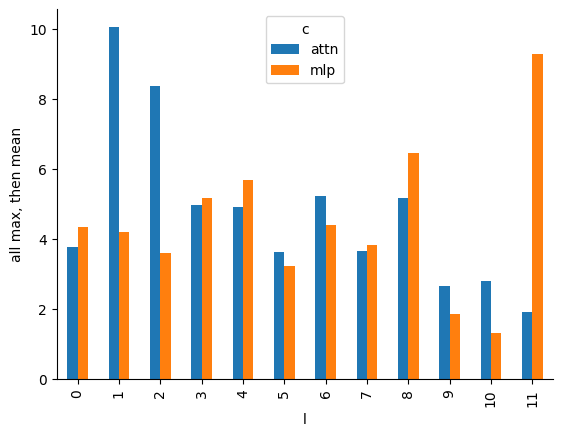

In [21]:
df = pd.DataFrame(list(zip(names,grads)), columns=['names','vals'])
df = pd.concat((df["names"].apply(pd.Series), df["vals"]), axis=1)

## group by layer and module type________________________________
df = df.drop(columns=[0,3], inplace=False)

df = df.rename(columns = {1:"l", 2:"c"})
lc_df = df.groupby(["l","c"]).agg({'vals': "mean"}).reset_index()
lc_df["l"] = lc_df["l"].astype(int)
lc_df = lc_df.sort_values(by=["l", "c"], ascending=True) ## sort by layers and c_types
lc_df = lc_df.pivot_table(index='l', columns='c', values='vals')

ax = lc_df.plot(kind='bar',figsize=(10, 2))
ax.set_ylabel("all max, then mean")

## Analyze Activation Gradients

In [22]:
#vals, c_names = collect_c_type(model=model, cache=None, c_type="W_in")
vals, c_names = modelHandlers.collect_c_type(model=model, cache=bwd_cache, c_type="mlp_in")
print(vals.shape)
vals = vals.mean(0)
vals = torch.max(vals,dim=-1)[0]
#vals = torch.max(torch.max(vals,dim=-1)[0], dim=-1)[0]
#vals =vals.mean(0).mean(-1) ## "mlp_out"
#vals = torch.abs(vals).mean(-1) ## "mlp_out"
#vals = torch.abs(vals).mean(-1).mean(-1) ## "k", "q", "v"
#vals, _ = torch.max(torch.abs(vals).mean(-1), dim=-1) ## "k", "q", "v"

#vals = vals.mean(-1)[...,10] ## "k", "q", "v"
print(vals.shape)

## normalization
#vals_norm = torch.einsum("LI,I->LI", vals[:,:-1], (1+(1/metric_norm))).detach().numpy()
vals_norm = vals
print(f"{c_names}\n{vals_norm.shape}")

returning ['blocks.0.hook_mlp_in', 'blocks.1.hook_mlp_in']... of shape: torch.Size([1, 12, 100, 768])
torch.Size([1, 12, 100, 768])
torch.Size([12, 100])
['blocks.0.hook_mlp_in', 'blocks.1.hook_mlp_in', 'blocks.2.hook_mlp_in', 'blocks.3.hook_mlp_in', 'blocks.4.hook_mlp_in', 'blocks.5.hook_mlp_in', 'blocks.6.hook_mlp_in', 'blocks.7.hook_mlp_in', 'blocks.8.hook_mlp_in', 'blocks.9.hook_mlp_in', 'blocks.10.hook_mlp_in', 'blocks.11.hook_mlp_in']
torch.Size([12, 100])


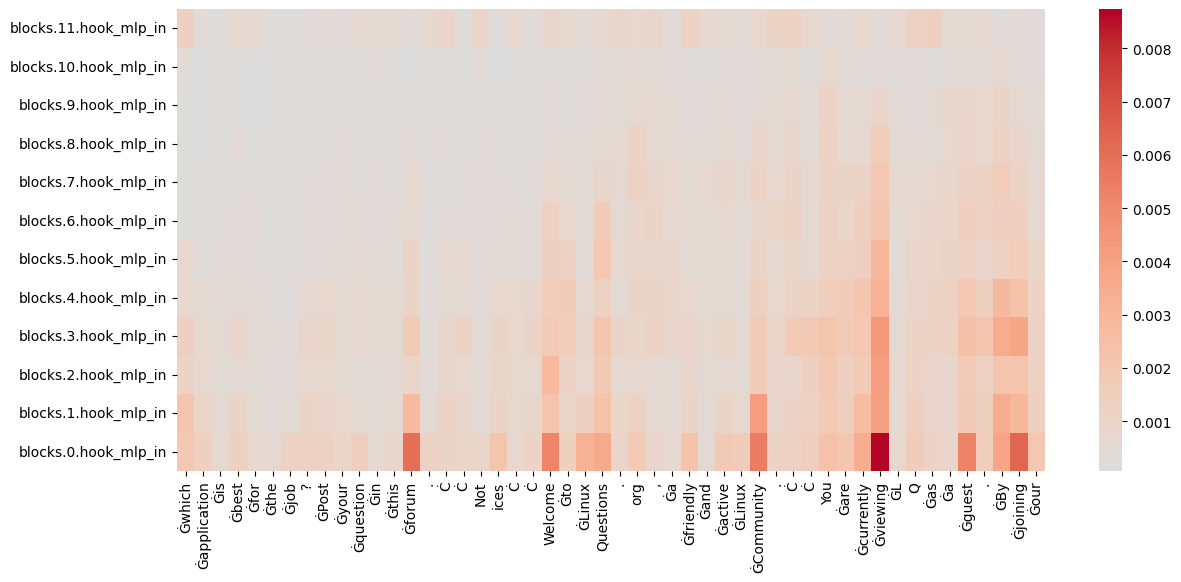

In [23]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

def plot_heatmap(vals:list, x_labels:list=None, y_labels:list=None):
    fig, ax = plt.subplots(1, 1, figsize=(14, 6), gridspec_kw={'hspace': 0.4})
    ax = sns.heatmap(vals,
                  cmap=mpl.colormaps["coolwarm"], center=0,
                  xticklabels=x_labels,
                  yticklabels=y_labels, square=False)
    ax.invert_yaxis()

plot_heatmap(vals_norm[...,:50], x_labels=model.tokenizer.convert_ids_to_tokens(c_toks_NI[0,...,:50]),y_labels=c_names)
#plot_heatmap(vals_norm[...,:], x_labels=model.tokenizer.convert_ids_to_tokens(c_toks_NI[0,...,:]),y_labels=c_names)